In [ ]:
#@title Download and unpack the data

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json


!kaggle competitions download -c paddy-disease-classification

!unzip /content/paddy-disease-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: train_images/downy_mildew/100992.jpg  
  inflating: train_images/downy_mildew/100995.jpg  
  inflating: train_images/downy_mildew/101015.jpg  
  inflating: train_images/downy_mildew/101020.jpg  
  inflating: train_images/downy_mildew/101022.jpg  
  inflating: train_images/downy_mildew/101024.jpg  
  inflating: train_images/downy_mildew/101034.jpg  
  inflating: train_images/downy_mildew/101050.jpg  
  inflating: train_images/downy_mildew/101078.jpg  
  inflating: train_images/downy_mildew/101096.jpg  
  inflating: train_images/downy_mildew/101103.jpg  
  inflating: train_images/downy_mildew/101114.jpg  
  inflating: train_images/downy_mildew/101119.jpg  
  inflating: train_images/downy_mildew/101142.jpg  
  inflating: train_images/downy_mildew/101177.jpg  
  inflating: train_images/downy_mildew/101178.jpg  
  inflating: train_images/downy_mildew/101181.jpg  
  inflating: train_images/downy_mildew/101205.jpg  
  inflating: 

In [ ]:
#@title imports

from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import torch
from torch import nn
from torchvision import transforms, models
import gc
from functools import partial
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

(480, 640)    10403
(640, 480)        4
Name: size, dtype: int64


,id,label,size
0,105179.jpg,tungro,"(480, 640)"
1,106287.jpg,tungro,"(480, 640)"
2,103654.jpg,tungro,"(480, 640)"
3,101576.jpg,tungro,"(480, 640)"
4,107148.jpg,tungro,"(480, 640)"
...,...,...,...
10402,108817.jpg,bacterial_leaf_blight,"(480, 640)"
10403,109910.jpg,bacterial_leaf_blight,"(480, 640)"
10404,101391.jpg,bacterial_leaf_blight,"(480, 640)"
10405,109514.jpg,bacterial_leaf_blight,"(480, 640)"


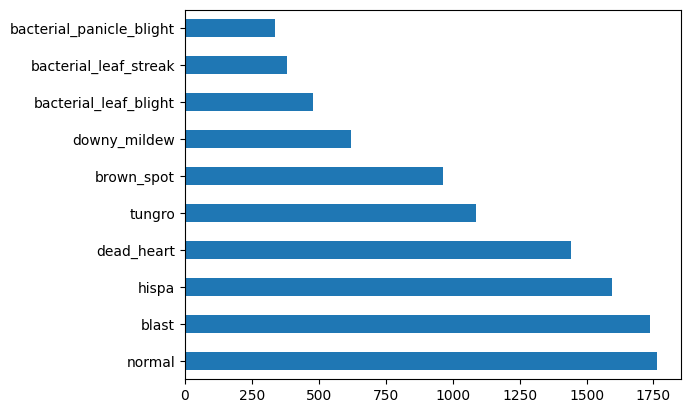

In [ ]:
#@title Get images info


def get_data():
  images = [(img_path.name, img_folder.name, Image.open(img_path).size) for img_folder in (Path("train_images")).iterdir() for img_path in img_folder.iterdir()]
  images = pd.DataFrame(data = images, columns=["id", "label", "size"])
  return images

data = get_data()
data.label.value_counts().plot.barh();
print(data["size"].value_counts()) 
data



In [ ]:
#@title Reduce size

def resize_imgs(df, dest, size):
  for _, row in df.iterrows():
    im = Image.open(Path("train_images")/row["label"]/row["id"])
    rim = im.resize(size)
    id = row["id"]
    label = row["label"]
    Path(f"{dest}/{label}").mkdir(parents=True, exist_ok=True)
    rim.save(f"{dest}/{label}/{id}")



resize_imgs(data, "train_sml", (244,244))

# Framework for training 

DataSet class creates a dataset with images and labels and applies nesessarry transformations.

![](https://drive.google.com/uc?export=view&id=1M4Cge1s3FG_ApiRD1oyFveorLO69e_dd)

In [ ]:
#@title DataSet class



from typing import Any, Tuple, Iterable, Optional, Callable

class BasicDataSet(torch.utils.data.Dataset):
    def __init__(self, x: Iterable, y: Iterable) -> None:
        self.x = x
        self.y = y

    def __getitem__(self, index: int) -> Tuple[Any, Any]: return (self.x[index], self.y[index])
    def __len__(self) -> int: return len(self.x)

class TrfDataSet(BasicDataSet):
    def __init__(self, x: Iterable, y: torch.tensor, transform: Optional[Callable] = None) -> None:
        super().__init__(x=x, y=y)
        self.transform = transform
        self.prefetched = {}

    def __getitem__(self, index) -> Tuple[Any, Any]: 
        item = self.prefetched.get(index, None)
        if item is None:
          item = self.x[index] 
          if self.transform is not None:
              item = self.transform(item)

        return item, self.y[index]

    def prefetch(self, prc: int, do_transform = True):
      n = (len(self.x)*prc)//100
      print(f"Fetching first {n} items")
      should_transform = (self.transform is not None) and (do_transform == True)
      self.prefetched = { idx : self.transform(item) if should_transform else item for idx, item in enumerate(self.x[:n]) }

def get_dataset(df, path, lable_encodings: dict, transforms = None):
  label_idx = df.label.replace(lable_encodings)
  label_idx = torch.tensor(label_idx.values)
  x_data = (path + "/" + df.label + "/" + df.id).values
  return TrfDataSet(x = x_data, y = label_idx, transform=transforms)

In [ ]:
#@title Stats estimation

def estimate_norms(dl, n):
  means = []
  stds = []
  for i, b in enumerate(dl):
    if(i >= n): break
    means.append(b[0].mean(dim=(0,2,3)))
    stds.append(b[0].std(dim=(0,2,3)))
  
  means = torch.stack(means)
  print(means.shape)
  stds = torch.stack(stds)
  
  return means.mean(0), stds.mean(0) 

# m,s = estimate_norms(train_dl, 10)
# m,s

In [ ]:
#@title Training loop

from tqdm import tqdm
import functools
import math

class Listener:
  _order = 0
  def before_fit(self): pass
  def after_batch(self): pass
  def after_epoch(self): pass
  def before_epoch(self): pass
  def after_fit(self): pass
  def after_epoch_full(self): pass # after both train and valid epochs


class ListenerList(Listener):
    def __init__(self, observers: Iterable[Listener], trainer = None): 
      if trainer is not None: 
        for obs in observers: obs.trainer = trainer
      self.observers = sorted(observers, key=lambda x: x._order)

    def register(self, trainer):
      for obs in self.observers: obs.trainer = trainer

    def __getattribute__(self, attr):
      if hasattr(Listener, attr): # redirect call to all childner if the method is from Observer
        def call_all(items, fn):
          for item in items:
            getattr(item, fn)()
        return functools.partial(call_all, self.observers, attr)
      else:
        return object.__getattribute__(self, attr) # do not redirect the call


class Trainer:
  def __init__(self, model, train_dl, valid_dl, opt_func, 
               lr, loss_func, cbs: Iterable[Listener], norms = None):
    self.model, self.train_dl, self.valid_dl, self.lr = model, train_dl, valid_dl, lr
    self.loss_func = loss_func
    self.opt_func = opt_func
    self.cbs = ListenerList(cbs)
    self.cbs.register(self)
    self.model.to(device)
    self.norms = transforms.Normalize(*norms) if norms is not None else None

  def _normalize(self, x):
    if self.norms is not None:
      x = self.norms(x)
    return x

  def one_batch(self, xb, yb):
        self.xb = self._normalize(xb.to(device))
        self.yb = yb.to(device)
        self.preds = self.model(self.xb)
        self.loss = self.loss_func(self.preds, self.yb)
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()
        self.cbs.after_batch()

  def one_epoch(self, train=True):
    self.model.training = train
    self.cbs.before_epoch()
    self.dl = self.train_dl if train else self.valid_dl
    for xb,yb in tqdm(self.dl, position=0, leave=True):
      self.one_batch(xb,yb)
    self.cbs.after_epoch()
    

  def fit(self, epochs):
      self.epochs = epochs
      self.opt = self.opt_func(self.model.parameters(), self.lr)
      self.cbs.before_fit()
      for e in range(epochs):
        self.epoch = e
        self.one_epoch()
        with torch.no_grad(): self.one_epoch(train=False)
        self.cbs.after_epoch_full()
      self.cbs.after_fit()

In [ ]:
#@title Metrics and stats

class EpochMetrics(Listener):
    def __init__(self, trainer=None):
      if trainer is not None: self.trainer = trainer

    def before_fit(self): 
      self.epoch_accs_train = []
      self.epoch_losses_train = []
      self.lrs = []

      self.epoch_accs_valid = []
      self.epoch_losses_valid = []
    
    def before_epoch(self): 
      self.training = self.trainer.model.training 
      self.epoch_accs = self.epoch_accs_train if self.training else self.epoch_accs_valid
      self.epoch_losses = self.epoch_losses_train if self.training else self.epoch_losses_valid
      
      lr = self.trainer.opt.param_groups[0]['lr']
      self.lrs.append(lr)

      self.batch_accs = []
      self.batch_losses = []

    def after_batch(self):
      with torch.no_grad(): 
          acc = (self.trainer.preds.argmax(dim=1)==self.trainer.yb).float().mean()

      self.batch_accs.append(acc.detach().item())
      self.batch_losses.append(self.trainer.loss.detach().item())

    def after_epoch(self):
      self.epoch_accs.append(sum(self.batch_accs)/len(self.batch_accs))
      self.epoch_losses.append(sum(self.batch_losses)/len(self.batch_losses))

    def after_epoch_full(self):
       df = pd.DataFrame([{
           "train_loss":self.epoch_losses_train[-1], # take the most recent value from the most recent epoch
           "valid_loss":self.epoch_losses_valid[-1],
           "valid_accuracy": self.epoch_accs_valid[-1]
       }], index = [self.trainer.epoch])

       display(df)
    

class BatchMetrics(Listener):
    def __init__(self, trainer=None):
      if trainer is not None: self.trainer = trainer

    def before_fit(self):
       self.accs_train = []
       self.losses_train = []

       self.accs_valid = []
       self.losses_valid = []

    def before_epoch(self):
        self.training = self.trainer.model.training 
        self.accs = self.accs_train if self.training else self.accs_valid
        self.losses = self.losses_train if self.training else self.losses_valid
          

    def after_batch(self):
        with torch.no_grad(): 
          acc = (self.trainer.preds.argmax(dim=1)==self.trainer.yb).float().mean()

        self.accs.append(acc.detach().item())
        self.losses.append(self.trainer.loss.detach().item())

    def after_fit(self):
      def _filter(data):
          f = torch.nn.AvgPool1d(kernel_size=10, stride=1)
          return f(torch.tensor(data).unsqueeze(0)).squeeze()

      def _plot(data, ax):
          data = _filter(data)
          ax.plot(np.arange(len(data)), data)  

      _, ax = plt.subplots(1, 4, figsize = (10,7))

       #plot accuracy
      ax[0].set_title("Accuracy train")
      _plot(self.accs_train, ax[0])
      
      ax[1].set_title("Accuracy valid")
      _plot(self.accs_valid, ax[1])
      
       #plot loss
      ax[2].set_title("Loss train")
      _plot(self.losses_train, ax[2])

      ax[3].set_title("Loss valid")
      _plot(self.losses_valid, ax[3])
        

class ActStats(Listener):
  def __init__(self, trainer=None):
      if trainer is not None: self.trainer = trainer

  def before_fit(self):
    def append_stats(i, stats, mod, inp, outp):
        out = outp.detach().to("cpu")
        stats.act_means[i].append(out.mean())
        stats.act_stds [i].append(out.std())
        stats.deads[i].append((out.numel() - out.count_nonzero())/out.numel())
      

    self.act_means = [[] for _ in self.trainer.model]
    self.act_stds  = [[] for _ in self.trainer.model]
    self.deads = [[] for _ in self.trainer.model]
    self.last_out = [None for _ in self.trainer.model]
      
    self.hooks = []  
    for i,layer in enumerate(self.trainer.model): 
      self.hooks.append(layer.register_forward_hook(functools.partial(append_stats, i, self)))

  def after_fit(self):
    for h in self.hooks:
      h.remove()

  def plot_acts(self):
    fig, ax = plt.subplots(len(self.act_means), figsize = (7,15))
    for i,l in enumerate(self.act_means): 
      ax[i].plot(l)
      ax[i].title.set_text(f"L {i}")

  def plot_stds(self):
    fig, ax = plt.subplots(len(self.act_stds), figsize = (7,15))
    for i,l in enumerate(self.act_stds): 
      ax[i].plot(l)
      ax[i].title.set_text(f"L {i}")

  def plot_deads(self):
    fig, ax = plt.subplots(1, len(self.deads), figsize = (20,5))
    for i,l in enumerate(self.deads): 
      ax[i].plot(l)
      ax[i].title.set_text(f"L {i}")

In [ ]:
#@title Learning rate scheduler

class LrScheduler(Listener):
  _order = 1 # should go after epoch metrics
  def __init__(self, sched, trainer=None): 
    self.sched_func = sched
    if trainer is not None: self.trainer = trainer
  def before_fit(self): 
    self.sched = self.sched_func(self.trainer.opt)
  def after_epoch(self):
     if self.trainer.model.training: self.sched.step()

[1, 0.9755282581485768, 0.9045084971884737, 0.7938926261472365, 0.6545084971884737, 0.500000000001, 0.3454915028135263, 0.2061073738547635, 0.09549150281352634, 0.024471741853423233, 1e-12, 0.024471741853423233, 0.09549150281352622]


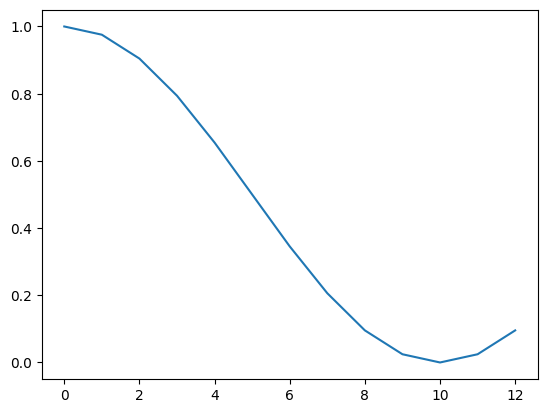

In [ ]:
#@title CosineLRCalculator

class CosineLRCalculator:
  def __init__(self, steps, min_lr = 1e-12):
    self.steps = steps
    self.min_lr = min_lr
  def __call__(self, epoch):
    if epoch == 0: return 1
    return (math.cos(math.pi*(epoch/self.steps)) + 1)*0.5 + self.min_lr

steps = 10
lr1 = CosineLRCalculator(steps)
lrs = [lr1(i) for i in range(steps + 3)]
plt.plot(np.arange(len(lrs)), lrs)
print(lrs)

[1, 0.9, 0.81, 0.7290000000000001, 0.6561, 0.5904900000000001, 0.531441, 0.4782969000000001, 0.4304672100000001, 0.3874204890000001, 0.3486784401000001, 0.31381059609000006, 0.2824295364810001]


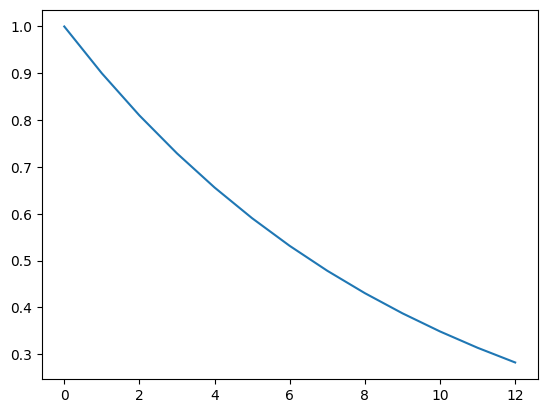

In [ ]:
#@title ExponentialLRCalculator

class ExponentialLRCalculator:
  def __init__(self, factor):
    self.factor = factor
  def __call__(self, epoch):
    if epoch == 0: return 1
    return (1 - self.factor)**epoch # every step decrease by factor %

steps = 10
lr1 = ExponentialLRCalculator(0.1)
lrs = [lr1(i) for i in range(steps + 3)]
plt.plot(np.arange(len(lrs)), lrs)
print(lrs)

In [ ]:
#@title ResNet
import copy

activation = nn.LeakyReLU(0.1)

def conv(ni, nf, stride, ks, act=True):
  layers = [nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2), nn.BatchNorm2d(nf)]
  if act: layers.append(activation)
  return nn.Sequential(*layers)

def _conv_block(ni,nf,stride,ks):
  return nn.Sequential(conv(ni, nf, stride=1, ks=ks), conv(nf, nf, stride=stride, act=False, ks=ks))

class FlattenLayer(nn.Module):
  def __init__(self): super(FlattenLayer, self).__init__()
  def forward(self, x):
    return x.view(x.size(0), -1) # flatten to Batch , acts


class ResidualBlock(nn.Module):
  def __init__(self, ni, nf, stride, ks):
    super(ResidualBlock, self).__init__()
    self.noop = lambda x: x
    self.convs = _conv_block(ni,nf,stride,ks)
    self.pool = self.noop if stride == 1 else nn.AvgPool2d(2, ceil_mode=True)
    self.correct_nf = self.noop if ni==nf else conv(ni, nf, stride=1, ks=1, act=False)
    self.relu = activation
  def forward(self, x):
    return self.relu(self.convs(x) + self.correct_nf(self.pool(x)))


def get_model():
  return nn.Sequential(
      conv(3,32,stride=1,ks=3),  
      nn.MaxPool2d(2),
      ResidualBlock(32, 32, stride = 1,ks=3),
      nn.MaxPool2d(2),
      ResidualBlock(32, 32, stride = 1,ks=3),
      nn.MaxPool2d(2),
      ResidualBlock(32, 64, stride = 1,ks=3),
      nn.MaxPool2d(2),
      ResidualBlock(64, 64, stride = 1,ks=3),
      nn.MaxPool2d(2),
      ResidualBlock(64, 64, stride = 1,ks=3),
      nn.MaxPool2d(2),
      ResidualBlock(64, 128, stride = 1,ks=3),
      nn.MaxPool2d(3), FlattenLayer(),
      nn.Linear(128, 128), nn.ReLU(), nn.Linear(128, 10)
  )

# Training

In [ ]:
torch.manual_seed(42);

In [ ]:
#@title Splint train/test | Stratified

def sample_by_lable(x, frac):
  s = int(len(x)*frac)
  return x.sample(s)

def sample_data(data, frac):
  sampled_data = data.copy()
  sampled_data = sampled_data.groupby("label", group_keys=False).apply(lambda x: sample_by_lable(x, frac))
  #sampled_data.to_csv(path/"sample.csv")
  return sampled_data

train_data = sample_data(data, 0.7)
valid_data = data.loc[~data.index.isin(train_data.index)]
train_data.reset_index(drop=True, inplace=True)
valid_data.reset_index(drop=True, inplace=True)
len(train_data), len(valid_data)

(7280, 3127)

In [ ]:
#@title Create dataloaders


label_encodings = {l:i for i,l in enumerate(set(data.label))} # get class label encodings

# Estimated norms
resnet18_norms = [(0.485, 0.456, 0.406), (0.229, 0.224, 0.225)]
rice_data_norms_244 = [(0.4953, 0.5879, 0.2374), (0.2283, 0.2320, 0.2093)]

data_path = "train_sml" 

transformations = transforms.Compose([Image.open, transforms.ToTensor()])

train_ds = get_dataset(train_data, 
                       data_path, 
                       label_encodings,
                       transformations)

valid_ds = get_dataset(valid_data, 
                       data_path, 
                       label_encodings,
                       transformations)

train_dl = torch.utils.data.DataLoader(train_ds, 64, shuffle = True, num_workers = 2)
valid_dl = torch.utils.data.DataLoader(valid_ds, 64, shuffle = True, num_workers = 2)

train_ds.prefetch(50)
valid_ds.prefetch(50)

Fetching first 3640 items
Fetching first 1563 items


## Training custom model

In [ ]:
model = get_model()
par = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"numer of parameters {par}")
model

numer of parameters 492682


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ResidualBlock(
    (convs): Sequential(
      (0): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1)
      )
      (1): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (relu): LeakyReLU(negative_slope=0.1)
  )
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): ResidualBlock(
    (convs): Sequential(
    

100%|██████████| 49/49 [00:06<00:00,  7.17it/s]


,train_loss,valid_loss,valid_accuracy
0,1.507904,1.071107,0.650951


100%|██████████| 49/49 [00:06<00:00,  7.47it/s]


,train_loss,valid_loss,valid_accuracy
1,0.885622,0.752306,0.749426


100%|██████████| 49/49 [00:05<00:00,  8.75it/s]


,train_loss,valid_loss,valid_accuracy
2,0.550786,0.552731,0.821655


100%|██████████| 49/49 [00:05<00:00,  8.59it/s]


,train_loss,valid_loss,valid_accuracy
3,0.326471,0.460681,0.8512


100%|██████████| 49/49 [00:06<00:00,  7.47it/s]


,train_loss,valid_loss,valid_accuracy
4,0.182482,0.330666,0.901681


100%|██████████| 49/49 [00:07<00:00,  6.92it/s]


,train_loss,valid_loss,valid_accuracy
5,0.086774,0.288208,0.907108


100%|██████████| 49/49 [00:05<00:00,  8.50it/s]


,train_loss,valid_loss,valid_accuracy
6,0.035906,0.253428,0.925597


100%|██████████| 49/49 [00:06<00:00,  7.59it/s]


,train_loss,valid_loss,valid_accuracy
7,0.017591,0.219077,0.93336


100%|██████████| 49/49 [00:06<00:00,  7.77it/s]


,train_loss,valid_loss,valid_accuracy
8,0.00759,0.213181,0.940057


100%|██████████| 49/49 [00:05<00:00,  8.61it/s]


,train_loss,valid_loss,valid_accuracy
9,0.005402,0.202393,0.940213


100%|██████████| 49/49 [00:05<00:00,  8.22it/s]


,train_loss,valid_loss,valid_accuracy
10,0.004964,0.2054,0.940161


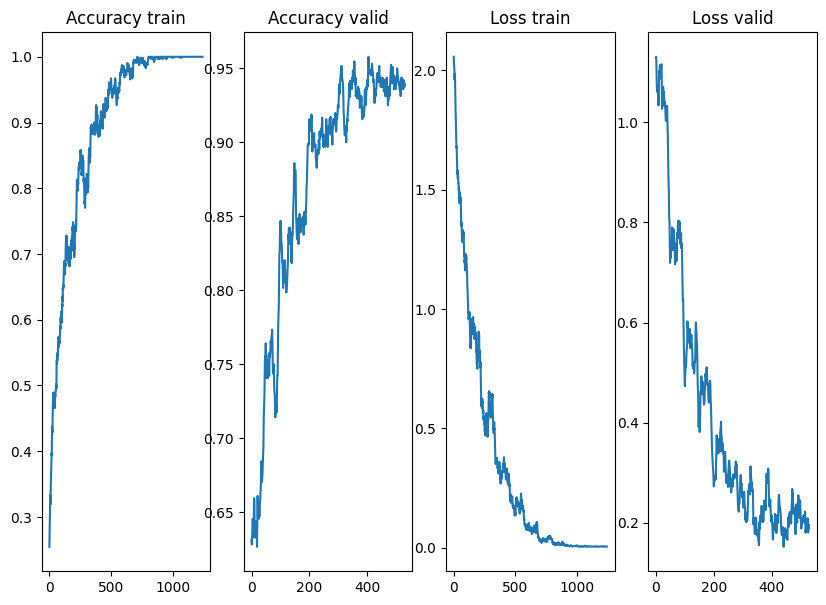

In [ ]:
eps = 11
model = get_model()
bm = BatchMetrics()
em = EpochMetrics()
opt = partial(torch.optim.AdamW, eps=1e-5)
sch = partial(torch.optim.lr_scheduler.LambdaLR, lr_lambda = CosineLRCalculator(eps))
tr = Trainer(model, train_dl, valid_dl, opt, 0.001, torch.nn.CrossEntropyLoss(),
             cbs = [em, bm, LrScheduler(sch)], norms = rice_data_norms_244) 
tr.fit(eps)

## Transfer learning

In [ ]:
#@title Create model
import copy

prentrained_model = models.resnet18(pretrained=True)

head = torch.nn.Sequential(FlattenLayer(),
                            torch.nn.Linear(512, 512),
                            torch.nn.ReLU(),
                            torch.nn.Linear(512, 10))

model = torch.nn.Sequential(*list(prentrained_model.children())[:-1], head)
model_copy = copy.deepcopy(model);
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
par = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"numer of parameters {par}")

numer of parameters 11444298


In [ ]:
#@title Freeze the pretrained model

def freeze(model):
  for param in model.parameters():
      param.requires_grad = False
  for param in model[-1:].parameters():
      param.requires_grad = True

def show_layers_grad(model):
  for layer in model.children():
    result= any([parameter.requires_grad for parameter in layer.parameters()])
    print(f"Layer {type(layer)}, {result}")

  

freeze(model)  
show_layers_grad(model)

Layer <class 'torch.nn.modules.conv.Conv2d'>, False
Layer <class 'torch.nn.modules.batchnorm.BatchNorm2d'>, False
Layer <class 'torch.nn.modules.activation.ReLU'>, False
Layer <class 'torch.nn.modules.pooling.MaxPool2d'>, False
Layer <class 'torch.nn.modules.container.Sequential'>, False
Layer <class 'torch.nn.modules.container.Sequential'>, False
Layer <class 'torch.nn.modules.container.Sequential'>, False
Layer <class 'torch.nn.modules.container.Sequential'>, False
Layer <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>, False
Layer <class 'torch.nn.modules.container.Sequential'>, True


100%|██████████| 49/49 [00:07<00:00,  6.52it/s]


,train_loss,valid_loss,valid_accuracy
0,1.615139,1.326305,0.552534


100%|██████████| 49/49 [00:07<00:00,  6.83it/s]


,train_loss,valid_loss,valid_accuracy
0,0.878209,0.657389,0.787054


100%|██████████| 49/49 [00:07<00:00,  6.83it/s]


,train_loss,valid_loss,valid_accuracy
1,0.398445,0.422316,0.870333


100%|██████████| 49/49 [00:06<00:00,  7.47it/s]


,train_loss,valid_loss,valid_accuracy
2,0.21389,0.405963,0.881754


100%|██████████| 49/49 [00:07<00:00,  7.00it/s]


,train_loss,valid_loss,valid_accuracy
3,0.140466,0.353388,0.899878


100%|██████████| 49/49 [00:06<00:00,  7.23it/s]


,train_loss,valid_loss,valid_accuracy
4,0.072284,0.375354,0.908331


100%|██████████| 49/49 [00:09<00:00,  5.44it/s]


,train_loss,valid_loss,valid_accuracy
5,0.054195,0.27018,0.931128


100%|██████████| 49/49 [00:07<00:00,  6.37it/s]


,train_loss,valid_loss,valid_accuracy
6,0.021642,0.225195,0.948667


100%|██████████| 49/49 [00:06<00:00,  7.42it/s]


,train_loss,valid_loss,valid_accuracy
7,0.004398,0.234988,0.952331


100%|██████████| 49/49 [00:06<00:00,  7.81it/s]


,train_loss,valid_loss,valid_accuracy
8,0.002486,0.220079,0.948771


100%|██████████| 49/49 [00:06<00:00,  7.81it/s]


,train_loss,valid_loss,valid_accuracy
9,0.001388,0.213927,0.953925


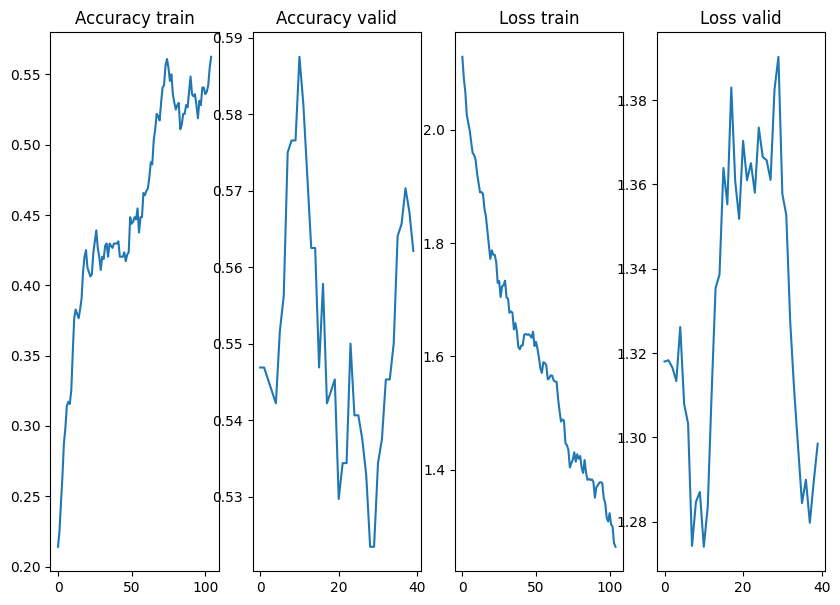

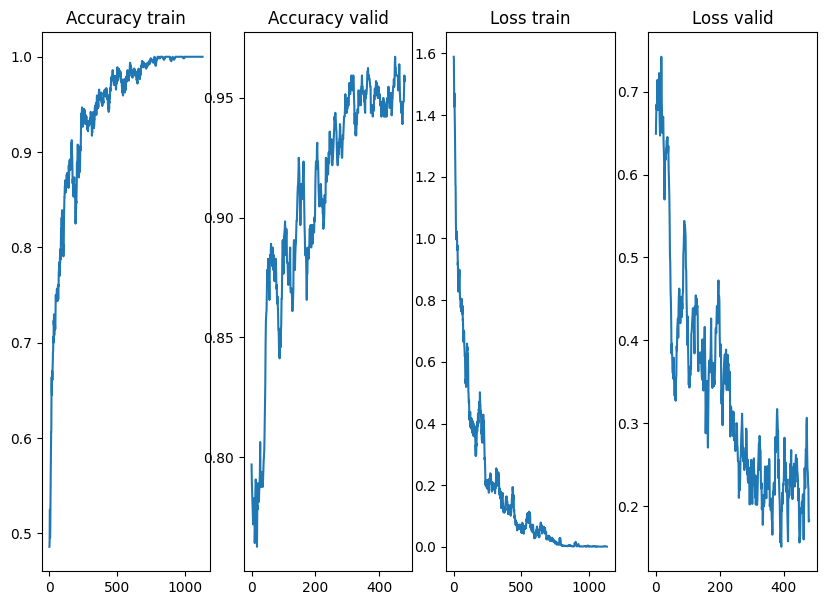

In [ ]:
#@title Fine-tune resnet18

eps = 11
bm = BatchMetrics()
em = EpochMetrics()
opt = partial(torch.optim.AdamW, eps=1e-5)
sch = partial(torch.optim.lr_scheduler.LambdaLR, lr_lambda = CosineLRCalculator(eps))
tr = Trainer(model, train_dl, valid_dl, opt, 0.001, torch.nn.CrossEntropyLoss(),
             cbs = [em, bm, LrScheduler(sch)], norms = resnet18_norms) 

tr.fit(1); # train head

# unfreeze the model
for param in model.parameters():
      param.requires_grad = True

tr.fit(eps - 1) #train all layers